# Notebook to create train & test set of images

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys
sys.path.append('scripts/')
import numpy as np
import matplotlib.pyplot as plt
import rasterio, rasterio.plot
import xarray as xr
import rioxarray as rxr
from tqdm import tqdm
import pandas as pd
import geopandas as gpd
import loadpaths
import land_cover_analysis as lca
import land_cover_visualisation as lcv


path_dict = loadpaths.loadpaths()

## Create shape file of list of tile names

In [3]:
## Save list to file:
# lca.save_tile_names_to_list(list_tile_names=list(df_tiles_eval['PLAN_NO'].unique()), text_filename='content/evaluation_sample_50tiles/evaluation_sample_50tiles_list.txt')
 
## Get list of tile names from text file:
with open('/home/tplas/repos/cnn-land-cover/content/tiles_few_changes/tiles_few_changes_list.txt', 'r') as f:
    tiles_unchanged = f.readlines()
tiles_unchanged = [x.rstrip('\n') for x in tiles_unchanged]

with open('/home/tplas/repos/cnn-land-cover/content/forest_tiles/forest_tiles_list.txt', 'r') as f:
    tiles_forest = f.readlines()
tiles_forest = [x.rstrip('\n') for x in tiles_forest]

In [4]:
## Select tiles by name & save as new shp file
df_tiles_unchanged = lca.select_tiles_from_list(list_tile_names=tiles_unchanged, 
                                 save_new_shp=False,
                                 new_shp_filename='content/tiles_few_changes/tiles_few_changes')

df_tiles_forest = lca.select_tiles_from_list(list_tile_names=tiles_forest, 
                                 save_new_shp=False)

## Get distribution of classes of tiles from shp

In [5]:
## LC polygons:
df_lc_80s, mapping_class_inds = lca.load_landcover(pol_path=os.path.join(path_dict['lc_80s_path']))

Text(0.5, 1.0, 'Distribution of LC of entire PD')

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


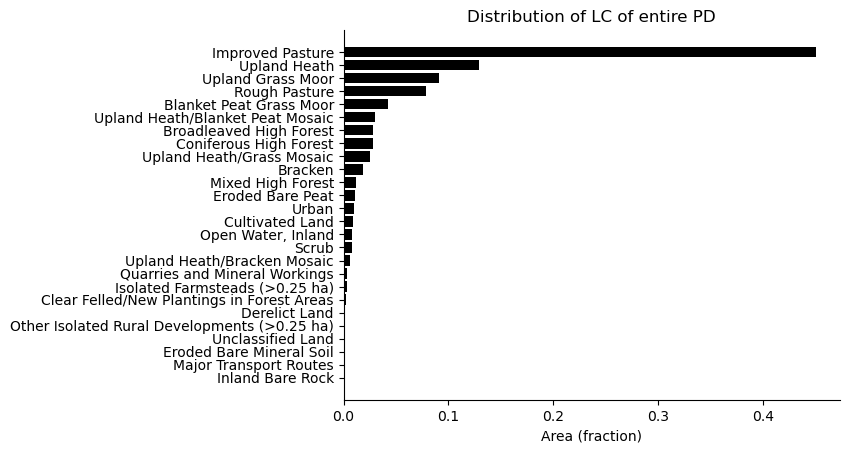

In [6]:
ax_distr, _ = lcv.plot_distr_classes_from_shape(df_lc=df_lc_80s)
ax_distr.set_title('Distribution of LC of entire PD')

## Process all tiles:

In [13]:
## Instead, we can use the existing shp file:
df_all_tiles = lca.get_shp_all_tiles()
# df_all_tiles = df_all_tiles.iloc[np.random.choice(a=2125, size=100, replace=False)]

In [14]:
## Get LC polygons for each tile, for all tiles:
dict_intersect_pols_all_tiles = lca.get_pols_for_tiles(df_pols=df_lc_80s, df_tiles=df_all_tiles, col_name='PLAN_NO')
dict_intersect_pols_tiles_unchanged = lca.get_pols_for_tiles(df_pols=df_lc_80s, df_tiles=df_tiles_unchanged, col_name='PLAN_NO')
dict_intersect_pols_tiles_forest = lca.get_pols_for_tiles(df_pols=df_lc_80s, df_tiles=df_tiles_forest, col_name='PLAN_NO')

100%|██████████| 5/5 [00:00<00:00, 27.83it/s]


In [15]:
## Calculate distribution of classes for each tile:
assert len(df_all_tiles) == 2125, 'Not expected number of tiles. Perhaps this is second pass?'
df_class_distr = lca.create_df_with_class_distr_per_tile(dict_dfs=dict_intersect_pols_all_tiles, 
                                                         all_class_names=list(df_lc_80s['LC_D_80'].unique()),
                                                         no_class_threshold=1.0)
df_all_tiles = df_all_tiles[np.isin(df_all_tiles['PLAN_NO'], df_class_distr['tile_name'])]
assert len(df_all_tiles) == len(df_class_distr)

2125it [00:06, 343.72it/s]

2125 tiles analysed
1617 tiles kept after no-class filter


In [16]:
## Calculate distribution of classes for each tile:
assert len(df_tiles_forest) == 5, 'Not expected number of tiles. Perhaps this is second pass?'
df_class_distr_forest = lca.create_df_with_class_distr_per_tile(dict_dfs=dict_intersect_pols_tiles_forest, 
                                                         all_class_names=list(df_lc_80s['LC_D_80'].unique()),
                                                         no_class_threshold=1.0)
df_forest_tiles = df_tiles_forest[np.isin(df_tiles_forest['PLAN_NO'], df_class_distr_forest['tile_name'])]
assert len(df_forest_tiles) == len(df_class_distr_forest)

5it [00:00, 150.59it/s]

5 tiles analysed
5 tiles kept after no-class filter


In [18]:
## Calculate distribution of classes for each tile:
assert len(df_tiles_unchanged) == 40, 'Not expected number of tiles. Perhaps this is second pass?'
df_class_distr_unchanged = lca.create_df_with_class_distr_per_tile(dict_dfs=dict_intersect_pols_tiles_unchanged, 
                                                         all_class_names=list(df_lc_80s['LC_D_80'].unique()),
                                                         no_class_threshold=1.0)
df_tiles_unchanged = df_tiles_unchanged[np.isin(df_tiles_unchanged['PLAN_NO'], df_class_distr_unchanged['tile_name'])]
assert len(df_tiles_unchanged) == len(df_class_distr_unchanged)

40it [00:00, 280.64it/s]

40 tiles analysed
40 tiles kept after no-class filter


In [18]:
df_class_distr['Broadleaved High Forest'].argsort()

0    3
1    0
2    4
3    1
4    2
Name: Broadleaved High Forest, dtype: int64

### Forest:
- SK2567 pretty good. 75% forest which is 80% correct maybe 
- SK2669 is great
- SK2377 great too
- SK2391, 50% coniferous or os
- SK2479 great for broadleaf 


In [79]:
list_forest_tiles = ['SK2567', 'SK2669', 'SK2377', 'SK2391', 'SK2479']
df_forest_tiles = lca.select_tiles_from_list(list_tile_names=list_forest_tiles, 
                                 save_new_shp=True,
                                 new_shp_filename='content/forest_tiles/forest_tiles')

## Get sample:

In [24]:
# df_class_distr_unchanged
df_class_distr_joint = pd.concat([df_class_distr_unchanged, df_class_distr_forest]).reset_index(drop=True)

In [38]:
distr_use

Improved Pasture                                0.372359
Upland Heath/Grass Mosaic                       0.041854
Upland Grass Moor                               0.085565
Blanket Peat Grass Moor                         0.079991
Rough Pasture                                   0.035754
Other Isolated Rural Developments (>0.25 ha)    0.000248
Open Water, Inland                              0.002516
Isolated Farmsteads (>0.25 ha)                  0.001920
Unclassified Land                               0.000058
Upland Heath/Blanket Peat Mosaic                0.049931
Bracken                                         0.005976
Upland Heath/Bracken Mosaic                     0.001249
Upland Heath                                    0.222472
Broadleaved High Forest                         0.026752
Coniferous High Forest                          0.019444
Derelict Land                                   0.000000
Urban                                           0.001326
Inland Bare Rock               

In [47]:
distr_use = df_class_distr_joint.sum(axis=0, numeric_only=True)
distr_use = distr_use / distr_use.sum() 
distr_use[20] = 0.2  # mixed high
distr_use[14] = 0.2 
distr_use[13] = 0.2
distr_use[0] = 0.1 
distr_use[4] = 0.15
distr_use[1] = 0.1
distr_use[2] = 0.1
distr_use[12] = 0.1 
distr_use[9] = 0.1 

distr_use = distr_use / distr_use.sum() 

distr_use 

# tmp

Improved Pasture                                0.073564
Upland Heath/Grass Mosaic                       0.073564
Upland Grass Moor                               0.073564
Blanket Peat Grass Moor                         0.058845
Rough Pasture                                   0.110346
Other Isolated Rural Developments (>0.25 ha)    0.000182
Open Water, Inland                              0.001851
Isolated Farmsteads (>0.25 ha)                  0.001412
Unclassified Land                               0.000043
Upland Heath/Blanket Peat Mosaic                0.073564
Bracken                                         0.004396
Upland Heath/Bracken Mosaic                     0.000919
Upland Heath                                    0.073564
Broadleaved High Forest                         0.147127
Coniferous High Forest                          0.147127
Derelict Land                                   0.000000
Urban                                           0.000975
Inland Bare Rock               

In [48]:
inds_tiles, df_lc_sample = lca.sample_tiles_by_class_distr_from_df(df_all_tiles_distr=df_class_distr_joint, 
                                                                    class_distr=distr_use,
                                                                   n_samples=10, iterations=30000)

Using predefined class distribution
At it 4 new loss of 0.9802163027653237
At it 8 new loss of 0.9762283658254305
At it 32 new loss of 0.9755505247566431
At it 38 new loss of 0.8020291770931018
At it 99 new loss of 0.7816008752437306
At it 121 new loss of 0.7782426882154995
At it 281 new loss of 0.7477408406281711
At it 339 new loss of 0.6373979278551194
At it 6909 new loss of 0.6145865323919848
At it 17948 new loss of 0.597015665890834
At it 18079 new loss of 0.5691939126603537


In [62]:
df_lc_sample

,tile_name,Improved Pasture,Upland Heath/Grass Mosaic,Upland Grass Moor,Blanket Peat Grass Moor,Rough Pasture,Other Isolated Rural Developments (>0.25 ha),"Open Water, Inland",Isolated Farmsteads (>0.25 ha),Unclassified Land,...,Inland Bare Rock,Eroded Bare Mineral Soil,Quarries and Mineral Workings,Mixed High Forest,Eroded Bare Peat,Scrub,Clear Felled/New Plantings in Forest Areas,Cultivated Land,Major Transport Routes,NO CLASS
44,SK2669,0.144336,0.000000,0.000000,0.000000,0.000000,0.0,0.018057,0.000000,0.000000,...,0.0,0.000000,0.0,0.486111,0.000000,0.047159,0.0,0.00000,0.000000,0.000004
5,SK0560,0.423187,0.285914,0.008837,0.000000,0.216287,0.0,0.000000,0.000000,0.000000,...,0.0,0.000000,0.0,0.000000,0.000000,0.001522,0.0,0.00000,0.000000,0.000002
1,SE1301,0.000000,0.000000,0.236549,0.740098,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.00000,0.000000,0.000004
26,SK1295,0.000000,0.374677,0.000000,0.248164,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.00000,0.000000,0.000012
43,SK2567,0.244455,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.002607,...,0.0,0.000000,0.0,0.582559,0.000000,0.000000,0.0,0.00000,0.000000,0.000000
42,SK2479,0.200963,0.000000,0.004851,0.000000,0.042769,0.0,0.000000,0.000000,0.000000,...,0.0,0.000000,0.0,0.015713,0.000000,0.000000,0.0,0.00000,0.031242,0.000004
41,SK2391,0.354336,0.000000,0.000000,0.000000,0.000000,0.0,0.090487,0.009475,0.000000,...,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.01025,0.000000,0.000002
18,SK1095,0.000000,0.000000,0.299472,0.269944,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.006008,0.0,0.000000,0.027939,0.000000,0.0,0.00000,0.000000,0.000004
9,SK0792,0.000000,0.109689,0.000000,0.098183,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.016889,0.0,0.000000,0.021920,0.000000,0.0,0.00000,0.000000,0.000000
12,SK0796,0.000000,0.000000,0.027094,0.050523,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.00000,0.000000,0.000000


In [63]:
df_tiles_joint = pd.concat([df_tiles_unchanged, df_tiles_forest]).reset_index(drop=True)
df_tiles_joint = df_tiles_joint[np.isin(df_tiles_joint['PLAN_NO'], df_lc_sample['tile_name'])]
df_tiles_joint.to_file('content/CDE_training_tiles/CDE_training_tiles.shp')


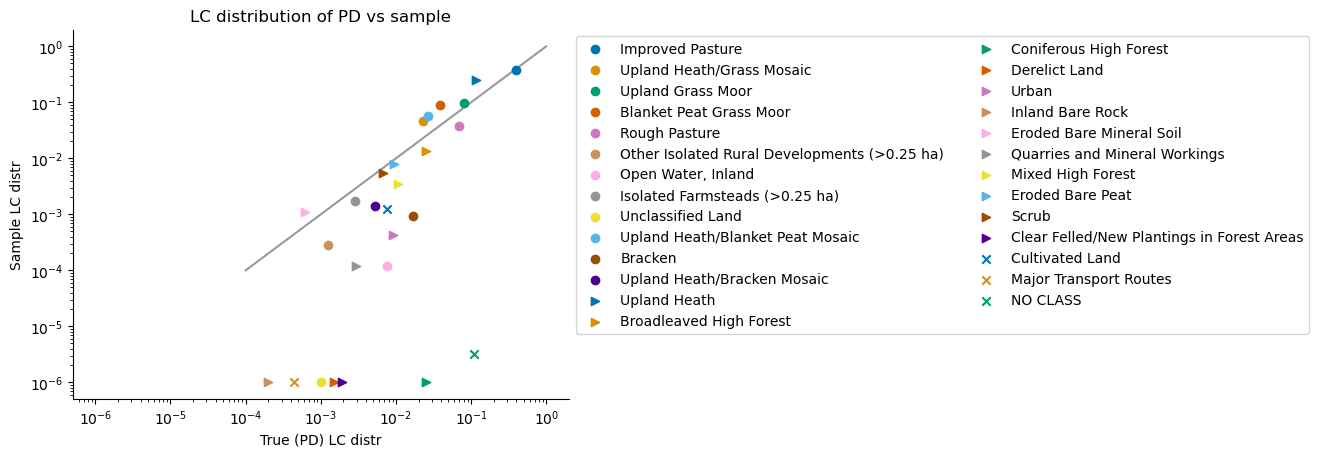

In [19]:
lcv.plot_scatter_class_distr_two_dfs(df_1=df_class_distr, df_2=df_class_distr_unchanged, save_fig=False)

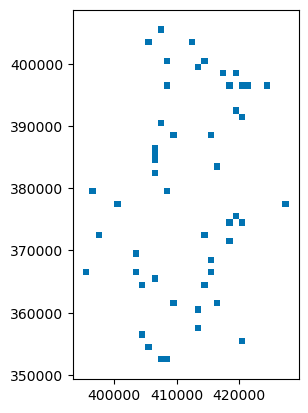

In [35]:
df_all_tiles.iloc[inds_tiles].plot()

In [39]:
df_tiles_sample = df_all_tiles.iloc[inds_tiles]
df_tiles_sample.to_file('content/evaluation_sample_50tiles/evaluation_sample_50tiles.shp')

### Load existing sample:

In [4]:
df_tiles_sample = gpd.read_file('content/evaluation_sample_50tiles/evaluation_sample_50tiles.shp')
## Get LC polygons for each tile, for all tiles:
dict_intersect_pols_sample_tiles = lca.get_pols_for_tiles(df_pols=df_lc_80s, df_tiles=df_tiles_sample, col_name='PLAN_NO')

100%|██████████| 50/50 [00:03<00:00, 15.07it/s]


In [5]:
## Calculate distribution of classes for each tile:
df_class_distr_sample = lca.create_df_with_class_distr_per_tile(dict_dfs=dict_intersect_pols_sample_tiles, 
                                                         all_class_names=list(df_lc_80s['LC_D_80'].unique()),
                                                         no_class_threshold=0.05)
assert len(df_class_distr_sample) == len(df_tiles_sample), 'no class filter deleted tiles => different filters must have been used'

50it [00:00, 339.69it/s]

50 tiles analysed
50 tiles kept after no-class filter


## Compare AREA column vs area calculation of polygon:

In [ ]:
# np.isclose(df_lc_80s['AREA'], df_lc_80s['geometry'].area).sum()
# 
plt.plot(df_lc_80s['AREA'], df_lc_80s['geometry'].area, '.')
plt.xlabel('Reported Area')
plt.ylabel('Polygon area')
print(np.where(np.abs(df_lc_80s['AREA'] - df_lc_80s['geometry'].area) > 1e4)[0])

In [ ]:
# i_pol = 37
# print(df_lc_80s.iloc[i_pol])
for i_pol in np.where(np.abs(df_lc_80s['AREA'] - df_lc_80s['geometry'].area) > 1e2)[0]:
    print(i_pol, df_lc_80s.iloc[i_pol]['LC_D_80'])
    print(f'Area of pol is {df_lc_80s.iloc[i_pol]["geometry"].area / 1e6} km^2, but DF says {df_lc_80s.iloc[i_pol]["AREA"] / 1e6}')


In [ ]:
df_lc_80s['AREA'].max() / 1e6

In [ ]:
print(f'Total area according to DF is {df_lc_80s["AREA"].sum() / 1e6} km^2 but according to pol {df_lc_80s["geometry"].area.sum() / 1e6} km^2')

In [ ]:
ax_distr, _ = lcv.plot_distr_classes_from_shape(df_lc=df_lc_80s)
ax_distr.set_title('Distribution of LC of entire PD')